In [4]:
import numpy as np
import cv2
import os
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [5]:
data_directory = 'H:\\299\images'

In [6]:
disease_classes = os.listdir(data_directory)

In [7]:
images = []
labels = []

In [8]:
# Load and preprocess images
for disease_class in disease_classes:
    class_directory = os.path.join(data_directory, disease_class)
    for image_file in os.listdir(class_directory):
        image_path = os.path.join(class_directory, image_file)
        
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Compute GLCM features
        glcm = graycomatrix(gray_image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast').flatten()
        correlation = graycoprops(glcm, 'correlation').flatten()
        energy = graycoprops(glcm, 'energy').flatten()
        homogeneity = graycoprops(glcm, 'homogeneity').flatten()
        
        # Concatenate GLCM features
        features = np.concatenate((contrast, correlation, energy, homogeneity))
        
        # Add the features and label to the lists
        images.append(features)
        labels.append(disease_class)

In [91]:
# Convert the lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

In [92]:
# Print the arrays
print(X)
print(y)

[[3.95473183 6.92252818 4.30922727 ... 0.4037547  0.49036009 0.40139429]
 [4.09868124 7.67061027 4.6607351  ... 0.40519118 0.49258564 0.40549239]
 [3.65029872 6.8705459  4.23326636 ... 0.41777336 0.5056671  0.41836314]
 ...
 [3.56887627 6.22892325 3.84281666 ... 0.41199946 0.50191247 0.41427835]
 [3.33567778 5.87604786 3.61094186 ... 0.4257942  0.51666167 0.42730399]
 [3.28799037 5.67211519 3.47789922 ... 0.43004476 0.52251486 0.43098425]]
['guava_diseased' 'guava_diseased' 'guava_diseased' ...
 'pomegranate_healthy' 'pomegranate_healthy' 'pomegranate_healthy']


In [93]:
# Perform label encoding on the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y)

[0 0 0 ... 9 9 9]


In [94]:
# Reshape the feature array for CNN input
X = X.reshape(X.shape[0], 4, 4, 1)
print(X.shape)
#print(X.shape[3])

(2273, 4, 4, 1)


In [95]:
# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [97]:
# Step 3: Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(4,4,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(disease_classes), activation='softmax'))

# input_shape = (32, 1, 1, 16)
# n_classes = 10

# model = models.Sequential([
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
# ])

In [98]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [99]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 2, 2, 32)          320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 10)                650       
                                                                 
Total params: 3,082
Trainable params: 3,082
Non-trainable params: 0
___________________________________________________

In [100]:
history = model.fit(
    X_train,
    to_categorical(y_train),
    epochs=50,
    batch_size=32,
    validation_data=(X_test, to_categorical(y_test))
)

Epoch 1/50
57/57 [==============================] - 1s 4ms/step - loss: 2.2471 - accuracy: 0.1414 - val_loss: 2.2353 - val_accuracy: 0.1648
Epoch 2/50
57/57 [==============================] - 0s 2ms/step - loss: 2.2094 - accuracy: 0.1595 - val_loss: 2.2250 - val_accuracy: 0.1495
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 2.1904 - accuracy: 0.2068 - val_loss: 2.1933 - val_accuracy: 0.2527
Epoch 4/50
57/57 [==============================] - 0s 1ms/step - loss: 2.1556 - accuracy: 0.2398 - val_loss: 2.1544 - val_accuracy: 0.2527
Epoch 5/50
57/57 [==============================] - 0s 1ms/step - loss: 2.0951 - accuracy: 0.2783 - val_loss: 2.0957 - val_accuracy: 0.2681
Epoch 6/50
57/57 [==============================] - 0s 2ms/step - loss: 2.0201 - accuracy: 0.2849 - val_loss: 2.0362 - val_accuracy: 0.2747
Epoch 7/50
57/57 [==============================] - 0s 2ms/step - loss: 1.9651 - accuracy: 0.2915 - val_loss: 1.9775 - val_accuracy: 0.3209
Epoch 8/50
57/57 [==

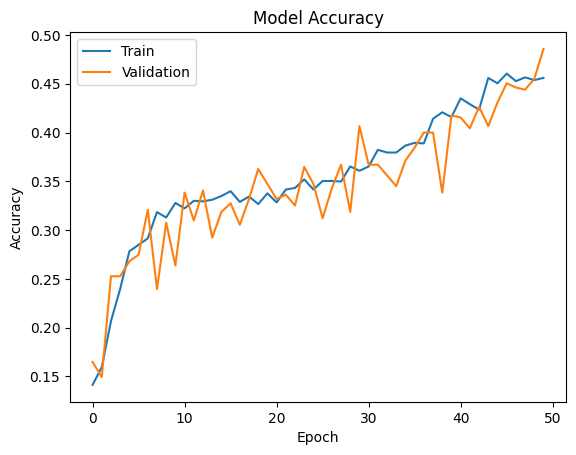

In [101]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

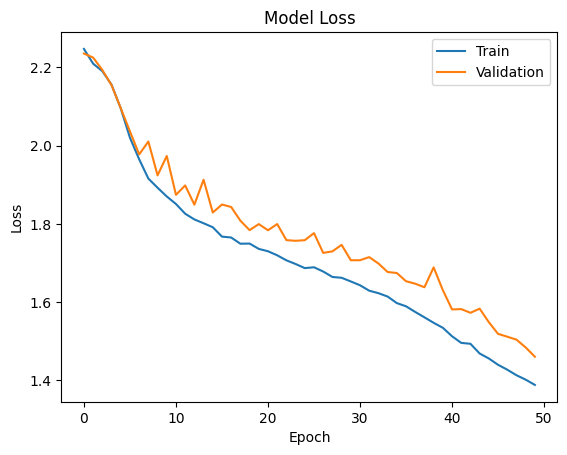

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()